In [ ]:
%cd ..
%env DWAVE_API_TOKEN=[token]
!source source.me

import os
from PIL import Image
import json
import sys
import numpy as np
import matplotlib.pyplot as plt
# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)

from models.autoencoders.gumboltCaloPRBM import GumBoltCaloPRBM
from models.samplers.pgbs import PGBS
import torch
from torch import nn
import matplotlib.pyplot as plt

from hydra import initialize, compose
from nbutils import *
from dwave.system import DWaveSampler

In [2]:
def find_partition_key(idx, qubit_idxs):
    for key in qubit_idxs.keys():
        if idx in qubit_idxs[key]:
            return key
def energy_exp(p0_state, p1_state, p2_state, p3_state, weight_dict, bias_dict):
        """Energy expectation value under the 4-partite BM
        Overrides energy_exp in gumbolt.py

        :param p0_state (torch.Tensor) : (batch_size, n_nodes_p1)
        :param p1_state (torch.Tensor) : (batch_size, n_nodes_p2)
        :param p2_state (torch.Tensor) : (batch_size, n_nodes_p3)
        :param p3_state (torch.Tensor) : (batch_size, n_nodes_p4)

        :return energy expectation value over the current batch
        """
        w_dict = weight_dict
        b_dict = bias_dict

        w_dict_cp = {}

        # Broadcast weight matrices (n_nodes_pa, n_nodes_pb) to
        # (batch_size, n_nodes_pa, n_nodes_pb)
        for key in w_dict.keys():
            w_dict_cp[key] = w_dict[key] + torch.zeros((p0_state.size(0),) +
                                                    w_dict[key].size(),
                                                    device=w_dict[key].device)

        # Prepare px_state_t for torch.bmm()
        # Change px_state.size() to (batch_size, 1, n_nodes_px)
        p0_state_t = p0_state.unsqueeze(2).permute(0, 2, 1)
        p1_state_t = p1_state.unsqueeze(2).permute(0, 2, 1)
        p2_state_t = p2_state.unsqueeze(2).permute(0, 2, 1)

        # Prepare py_state for torch.bmm()
        # Change py_state.size() to (batch_size, n_nodes_py, 1)
        p1_state_i = p1_state.unsqueeze(2)
        p2_state_i = p2_state.unsqueeze(2)
        p3_state_i = p3_state.unsqueeze(2)

        # Compute the energies for batch samples
        batch_energy = torch.matmul(p0_state, b_dict['0']) + \
            torch.matmul(p1_state, b_dict['1']) + \
            torch.matmul(p2_state, b_dict['2']) + \
            torch.matmul(p3_state, b_dict['3']) + \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['01'], p1_state_i)).reshape(-1) + \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['02'], p2_state_i)).reshape(-1) + \
            torch.bmm(p0_state_t,
                      torch.bmm(w_dict_cp['03'], p3_state_i)).reshape(-1) + \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['12'], p2_state_i)).reshape(-1) + \
            torch.bmm(p1_state_t,
                      torch.bmm(w_dict_cp['13'], p3_state_i)).reshape(-1) + \
            torch.bmm(p2_state_t,
                      torch.bmm(w_dict_cp['23'], p3_state_i)).reshape(-1)

        return batch_energy

In [3]:
def build_model(n_of_nodes_per_layer = 128, weight_scle=1.0, bias_scale=1.0, weight_bias = 0.0, bias_bias = 0.0, _device = 'cpu'):
        with initialize(config_path="../configs"):
                cfg = compose(config_name="config")
        cfg['model']['n_latent_nodes'] = n_of_nodes_per_layer
        model = GumBoltCaloPRBM(flat_input_size=[504],
                                train_ds_mean=0.,
                                activation_fct=torch.nn.ReLU(),
                                cfg=cfg)
        model.create_networks()
        for key in model.prior.weight_dict.keys():
                model.prior.weight_dict[key] = model.prior.weight_dict[key] * weight_scle + weight_bias
                model.prior.weight_dict[key] = model.prior.weight_dict[key]
        for key in model.prior.bias_dict.keys():
                model.prior.bias_dict[key] = model.prior.bias_dict[key] * bias_scale + bias_bias
                model.prior.bias_dict[key] = model.prior.bias_dict[key]
        model.prior._qubit_idx_dict, device = model.prior.gen_qubit_idx_dict()
        model.to(_device)
        return model


In [4]:
def create_ising(model, beta=1.0):
    prbm_weights = {}
    prbm_bias = {}
    for key in model.prior.weight_dict.keys():
        prbm_weights[key] = model.prior.weight_dict[key]
    for key in model.prior.bias_dict.keys():
        prbm_bias[key] = model.prior.bias_dict[key]
        
    prbm_edgelist = model.prior._pruned_edge_list

    idx_dict = model.prior._qubit_idx_dict

    qubit_idxs = idx_dict['0'] + idx_dict['1'] + idx_dict['2'] + idx_dict['3']

    idx_map = {}
    for key in idx_dict.keys():
        idx_map[key] = {idx:i for i, idx in enumerate(idx_dict[key])}


    dwave_weights = {}
    dwave_bias = {}

    for key in prbm_weights.keys():
        dwave_weights[key] = - prbm_weights[key]/4.
    for key in prbm_bias.keys():
        s = torch.zeros(prbm_bias[key].size(), device=prbm_bias[key].device)
        for i in range(4):
            if i > int(key):
                wKey = key + str(i)
                s = s - torch.sum(prbm_weights[wKey], dim=1)/4.
            elif i < int(key):
                wKey = str(i) + key
                s = s - torch.sum(prbm_weights[wKey], dim=0)/4.
        dwave_bias[key] = - prbm_bias[key]/2.0 + s
    dwave_weights_scaled = {}
    dwave_bias_scaled = {}
    for key in dwave_weights.keys():
        dwave_weights_scaled[key] = dwave_weights[key] / beta
    for key in dwave_bias.keys():
        dwave_bias_scaled[key] = dwave_bias[key] / beta

    dwave_weights_np = {}
    for key in dwave_weights_scaled.keys():
        dwave_weights_np[key] = dwave_weights_scaled[key].detach().cpu().numpy()
    biases = torch.cat([dwave_bias_scaled[key] for key in dwave_bias_scaled.keys()])

    h = {qubit_idx:bias for qubit_idx, bias in zip(qubit_idxs, biases)}
    J = {}
    for edge in prbm_edgelist:
        partition_edge_0 = find_partition_key(edge[0], idx_dict)
        partition_edge_1 = find_partition_key(edge[1], idx_dict)
        if int(partition_edge_0) < int(partition_edge_1):
            wKey = partition_edge_0 + partition_edge_1
            J[edge] = dwave_weights_np[wKey][idx_map[partition_edge_0][edge[0]]][idx_map[partition_edge_1][edge[1]]]
        elif int(partition_edge_0) > int(partition_edge_1):
            wKey = partition_edge_1 + partition_edge_0
            J[edge] = dwave_weights_np[wKey][idx_map[partition_edge_1][edge[1]]][idx_map[partition_edge_0][edge[0]]]
    return h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias

In [5]:
def plot_energies(rbm_energy_list, scaled_dwave_energies, beta,binwidth =3):
    data = np.concatenate((rbm_energy_list,scaled_dwave_energies), axis=0)
    bins =  np.arange(min(data), max(data) + binwidth, binwidth)
    plt.hist(rbm_energy_list, bins = bins, edgecolor='darkblue', linewidth=0.5, color = "white", label='RBM',density=True)
    plt.hist(scaled_dwave_energies, alpha=0.5, bins = bins, label='DWAVE',density=True)
    plt.legend(loc='upper right')
    plt.title(f'Energy Distribution beta = {beta:.3f}')

In [6]:
gpu = 4
qpu_sampler = DWaveSampler(solver={"topology__type":"pegasus"})
device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")
model = build_model(n_of_nodes_per_layer = 128, _device=device)

2023-11-01 16:22:27,760 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[16:22:27.760] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-11-01 16:22:28,356 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[16:22:28.356] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-11-01 16:22:33,243 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[16:22:33.243] INFO   dwave.cloud.client.base                

40105 3335
Initializing NetworkV3


2023-11-01 16:22:40,950 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[16:22:40.950] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-11-01 16:22:41,243 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[16:22:41.243] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-11-01 16:22:45,710 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[16:22:45.710] INFO   dwave.cloud.client.base                

In [20]:
beta_init = 10.0
lr = 0.01
num_epochs = 20
beta = beta_init
beta_list = []
rbm_energy_list = []
dwave_energies_list = []
mean_rbm_energy_list = []
mean_dwave_energy_list = []
training_results = {}

for epoch in range(num_epochs+1):
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = create_ising(model, beta=beta)
    if epoch == 0:
        prbm_sampler = PGBS(model.prior, 512, 3000)
        p0_state, p1_state, p2_state, p3_state = prbm_sampler.block_gibbs_sampling()
        p0_ising = p0_state * 2 - 1
        p1_ising = p1_state * 2 - 1
        p2_ising = p2_state * 2 - 1
        p3_ising = p3_state * 2 - 1
        rbm_energies = energy_exp(p0_ising, p1_ising, p2_ising, p3_ising, dwave_weights, dwave_bias)
        rbm_energies = rbm_energies.detach().cpu().numpy()

    response = qpu_sampler.sample_ising(h, J, num_reads=256, auto_scale=False)
    dwave_samples, dwave_energies = batch_dwave_samples(response, qubit_idxs)
    nonpl = len(idx_dict['0'])
    dwave_1, dwave_2, dwave_3, dwave_4 = dwave_samples[:,0:nonpl], dwave_samples[:,nonpl:2*nonpl], dwave_samples[:,2*nonpl:3*nonpl], dwave_samples[:,3*nonpl:4*nonpl]
    dwave_1_t = torch.tensor(dwave_1).to(device).float()
    dwave_2_t = torch.tensor(dwave_2).to(device).float()
    dwave_3_t = torch.tensor(dwave_3).to(device).float()
    dwave_4_t = torch.tensor(dwave_4).to(device).float()
    dwave_energies = energy_exp(dwave_1_t, dwave_2_t, dwave_3_t, dwave_4_t, dwave_weights, dwave_bias)
    dwave_energies = dwave_energies.detach().cpu().numpy()
    mean_rbm_energy = np.mean(rbm_energies)
    mean_dwave_energy = np.mean(dwave_energies)

    rbm_energy_list.append(rbm_energies)
    dwave_energies_list.append(dwave_energies)
    mean_rbm_energy_list.append(mean_rbm_energy)
    mean_dwave_energy_list.append(mean_dwave_energy)
    beta_list.append(beta)
    print (f'Epoch {epoch}: beta = {beta}')
    beta = beta - lr * (mean_dwave_energy - mean_rbm_energy)
beta = beta_list[-1]

Epoch 0: beta = 10.0
Epoch 1: beta = 8.714645385742188
Epoch 2: beta = 7.735368041992188
Epoch 3: beta = 6.974100952148437
Epoch 4: beta = 6.379725952148437
Epoch 5: beta = 5.9281286621093745
Epoch 6: beta = 5.5823046875
Epoch 7: beta = 5.384042053222656
Epoch 8: beta = 5.221885681152343
Epoch 9: beta = 5.137467651367187
Epoch 10: beta = 5.0146588134765615
Epoch 11: beta = 4.899033813476562
Epoch 12: beta = 4.854605712890624
Epoch 13: beta = 4.8369421386718745
Epoch 14: beta = 4.791033935546874
Epoch 15: beta = 4.770918579101561
Epoch 16: beta = 4.741016845703124
Epoch 17: beta = 4.718490600585936
Epoch 18: beta = 4.695389099121092
Epoch 19: beta = 4.6697335815429675
Epoch 20: beta = 4.670354003906248


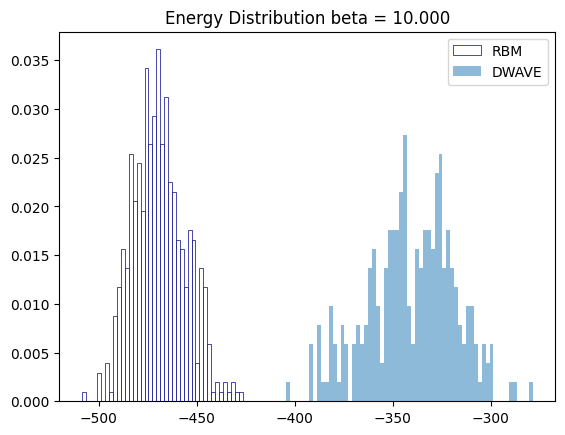

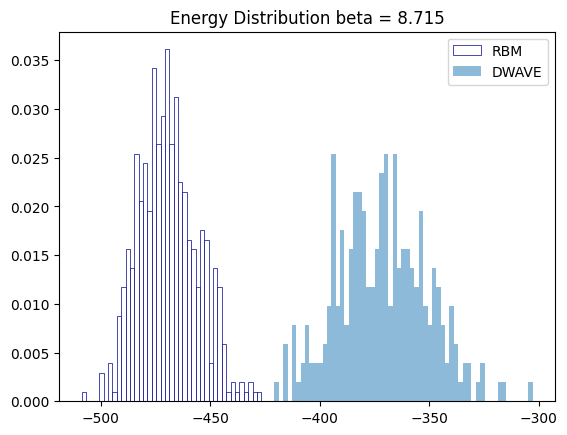

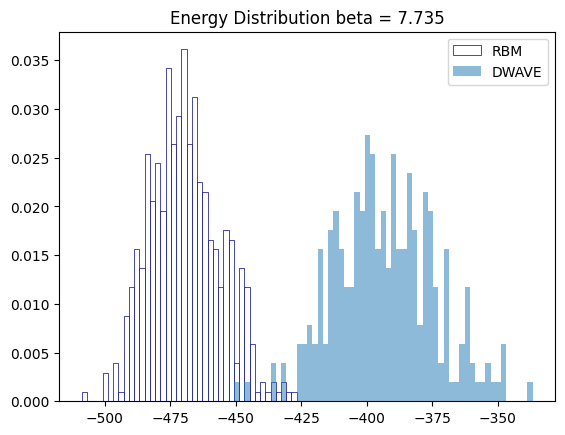

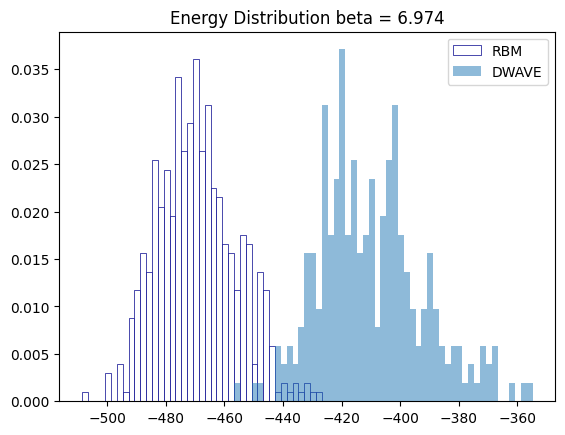

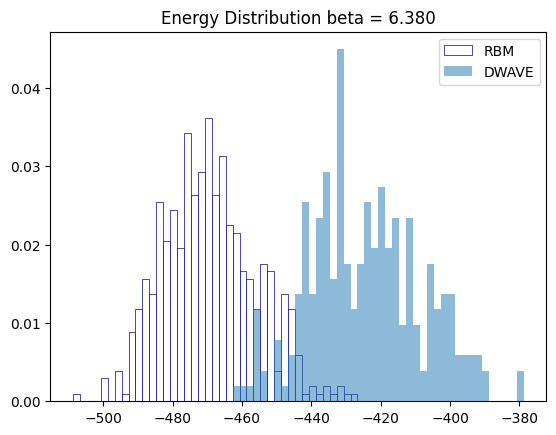

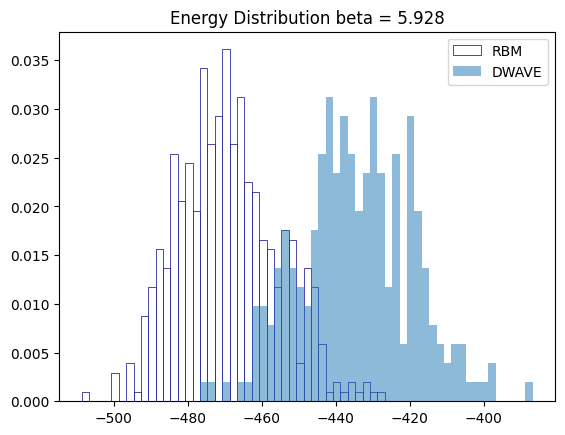

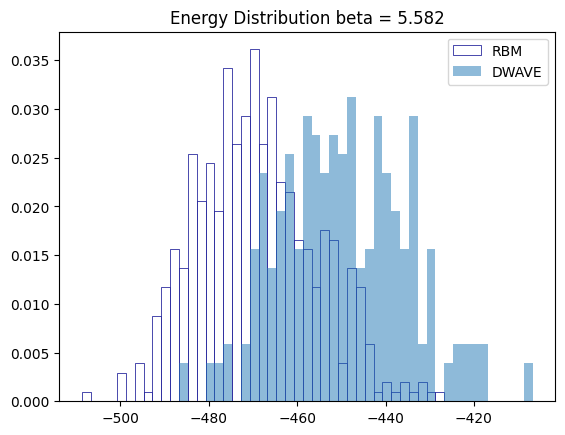

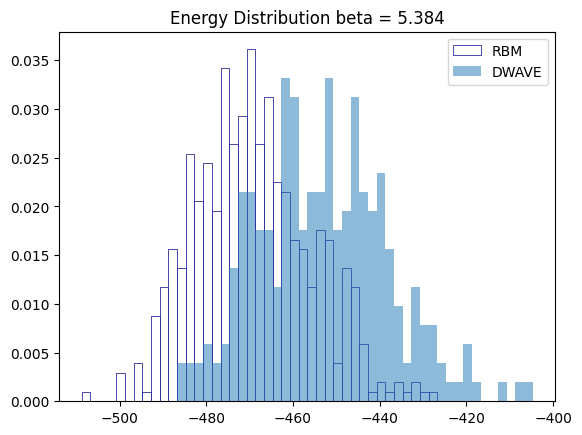

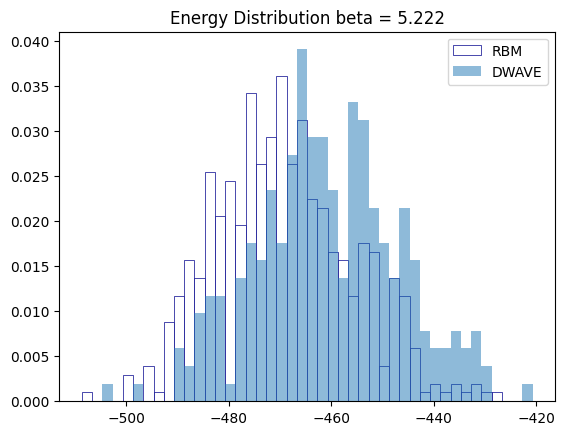

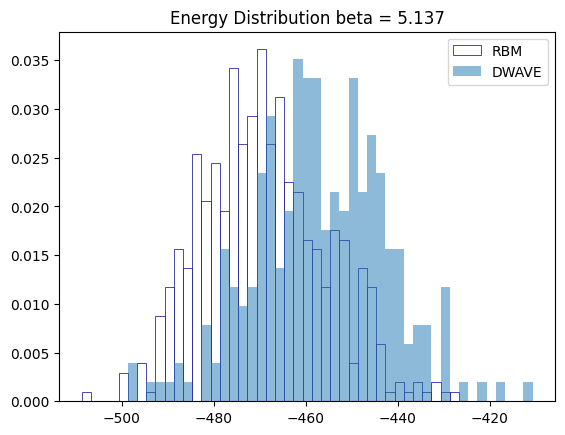

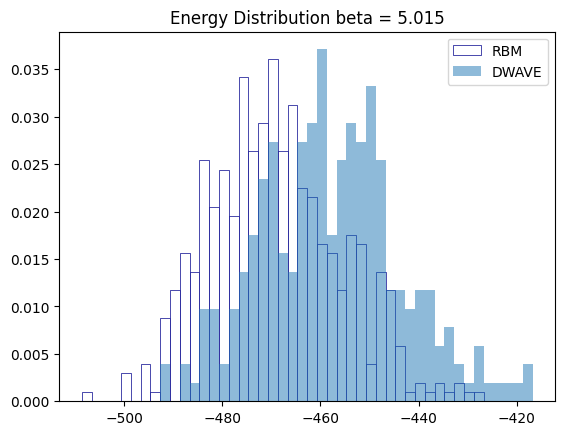

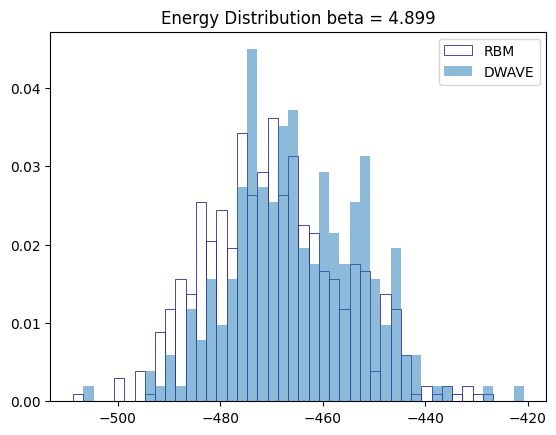

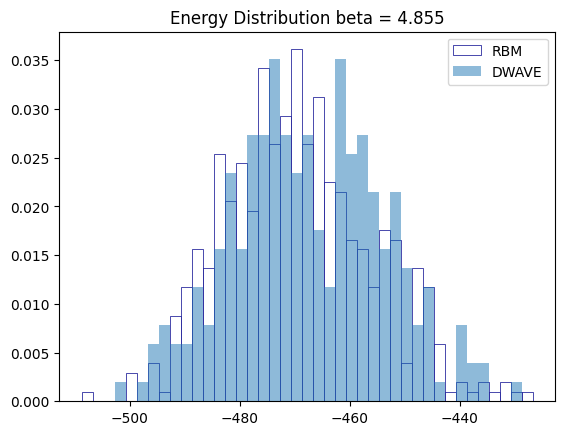

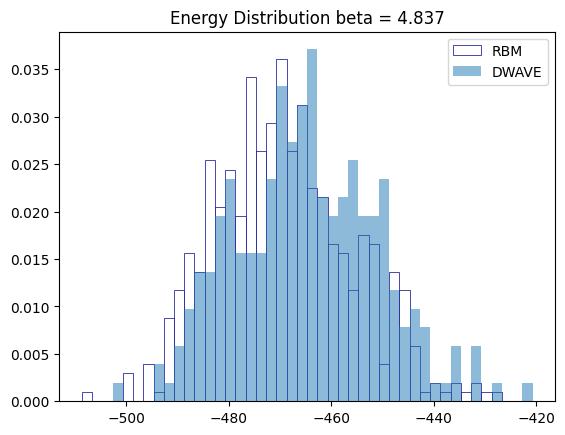

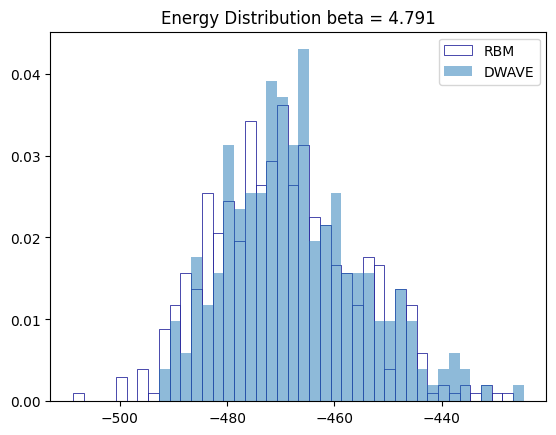

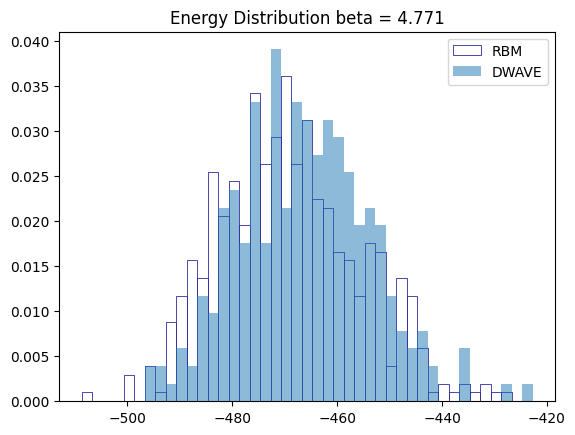

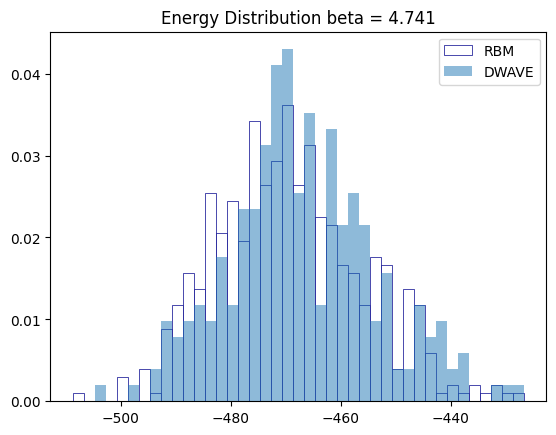

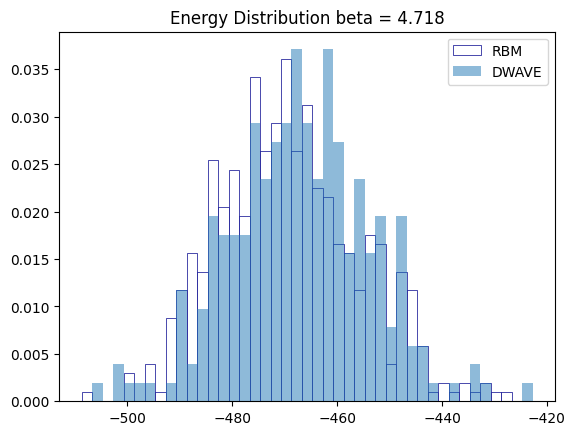

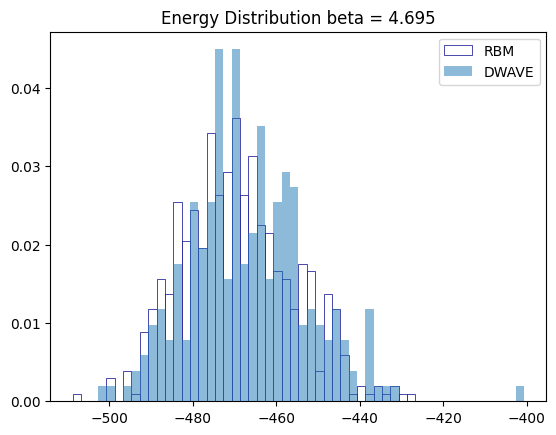

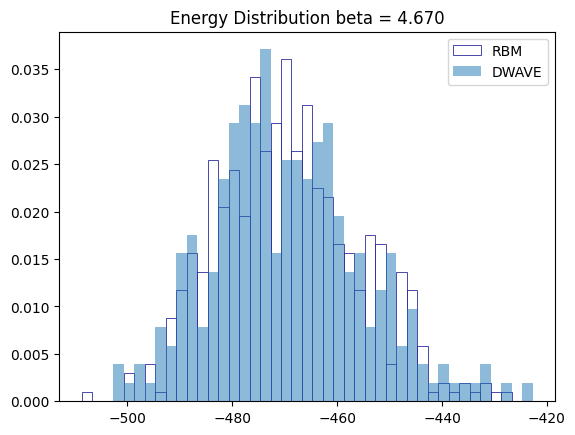

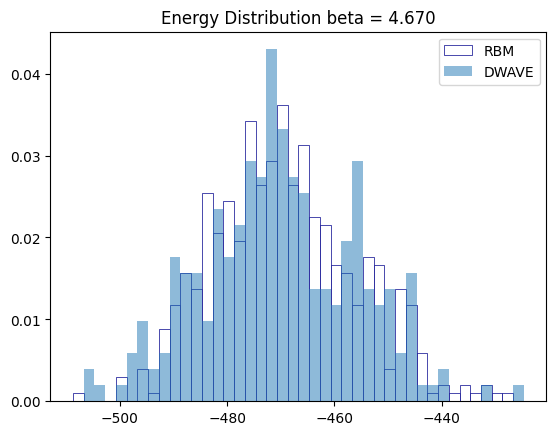

In [21]:
# Plot the energy distributions for each epoch and save them as png files in the beta_estimation folder
img_dir = './notebooks/beta_estimation/' 
for item in range(num_epochs+1):
    plot_energies(rbm_energy_list[item], dwave_energies_list[item], beta = beta_list[item], binwidth=2)
    plt.savefig(os.path.join(img_dir, f"{item}.png"))
    plt.show()
# Create the animated gif from the png files
resolution = (556, 435) 
img_list = []
for i in range(0, num_epochs+1):
    img = Image.open(os.path.join(img_dir, f'{i}.png')).resize(resolution)
    img_list.append(img)
img_list[0].save(os.path.join(img_dir,'animated.gif'), save_all=True, append_images=img_list[1:], loop=0, duration=300)

# Save results to json file
training_results['n_epoches'] = num_epochs
training_results['learning rate'] = lr
training_results['final_beta'] = beta
training_results['beta_list'] = beta_list
training_results['rbm_energy_list'] = rbm_energy_list
training_results['dwave_energies_list'] = dwave_energies_list
training_results['mean_rbm_energy_list'] = mean_rbm_energy_list
training_results['mean_dwave_energy_list'] = mean_dwave_energy_list
np.save(os.path.join(img_dir, 'training_results.npy'), training_results)

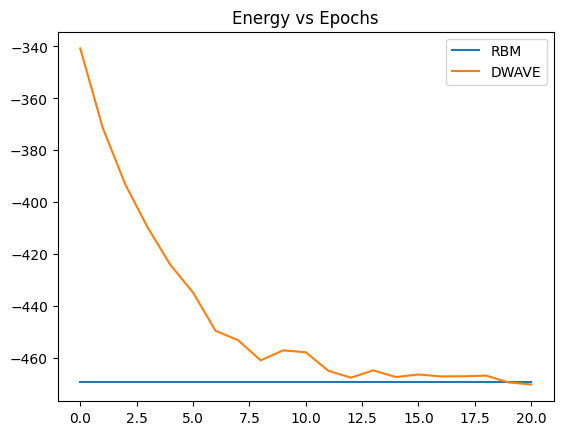

In [22]:
# Plot the mean energy vs epochs for RBM and DWAVE.
X = np.linspace(0, num_epochs, num_epochs+1)
plt.plot(X, mean_rbm_energy_list, label='RBM')
plt.plot(X, mean_dwave_energy_list, label='DWAVE')
plt.legend(loc='upper right')
plt.title(f'Energy vs Epochs')
plt.show()

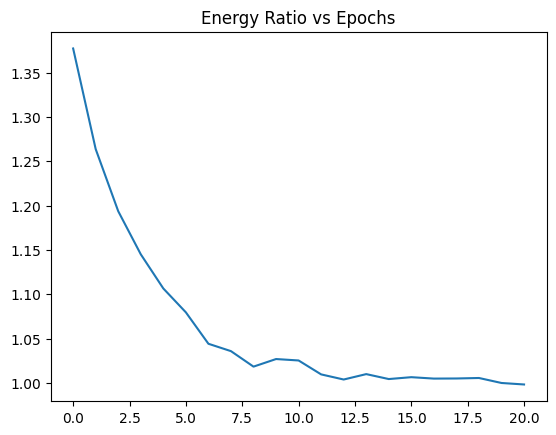

In [23]:
# Plot the energy ratio vs epochs.
plt.plot(np.array(mean_rbm_energy_list)/np.array(mean_dwave_energy_list))
plt.title(f'Energy Ratio vs Epochs')
plt.show()